In [2]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

import tarfile
import urllib

!pip install seaborn
!pip install yellowbrick

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer



from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler


You should consider upgrading via the 'C:\Users\Oskar\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Oskar\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


https://medium.com/@dennisndungu68/text-classification-using-k-means-33bea24e4a94

https://realpython.com/k-means-clustering-python/#how-to-build-a-k-means-clustering-pipeline-in-python

https://towardsdatascience.com/kmeans-clustering-for-classification-74b992405d0a


In [3]:
df = pd.read_csv(r'master.csv')

In [4]:
vectorizer = TfidfVectorizer(analyzer='word', min_df=0, stop_words='english')

#data = vectorizer.fit_transform(df["clean_abstract"]).toarray()

'''
Istedenfor å bruke tfidf-vektorer, bruker vi embeddings lagd av bert
'''

embeddings = np.load(r'embeddings_clean_context.npy')

data = embeddings

0.07172858
2  no. of clusters yields an average silhuette score of:  0.07172858
0.06663623
3  no. of clusters yields an average silhuette score of:  0.06663623


KeyboardInterrupt: 

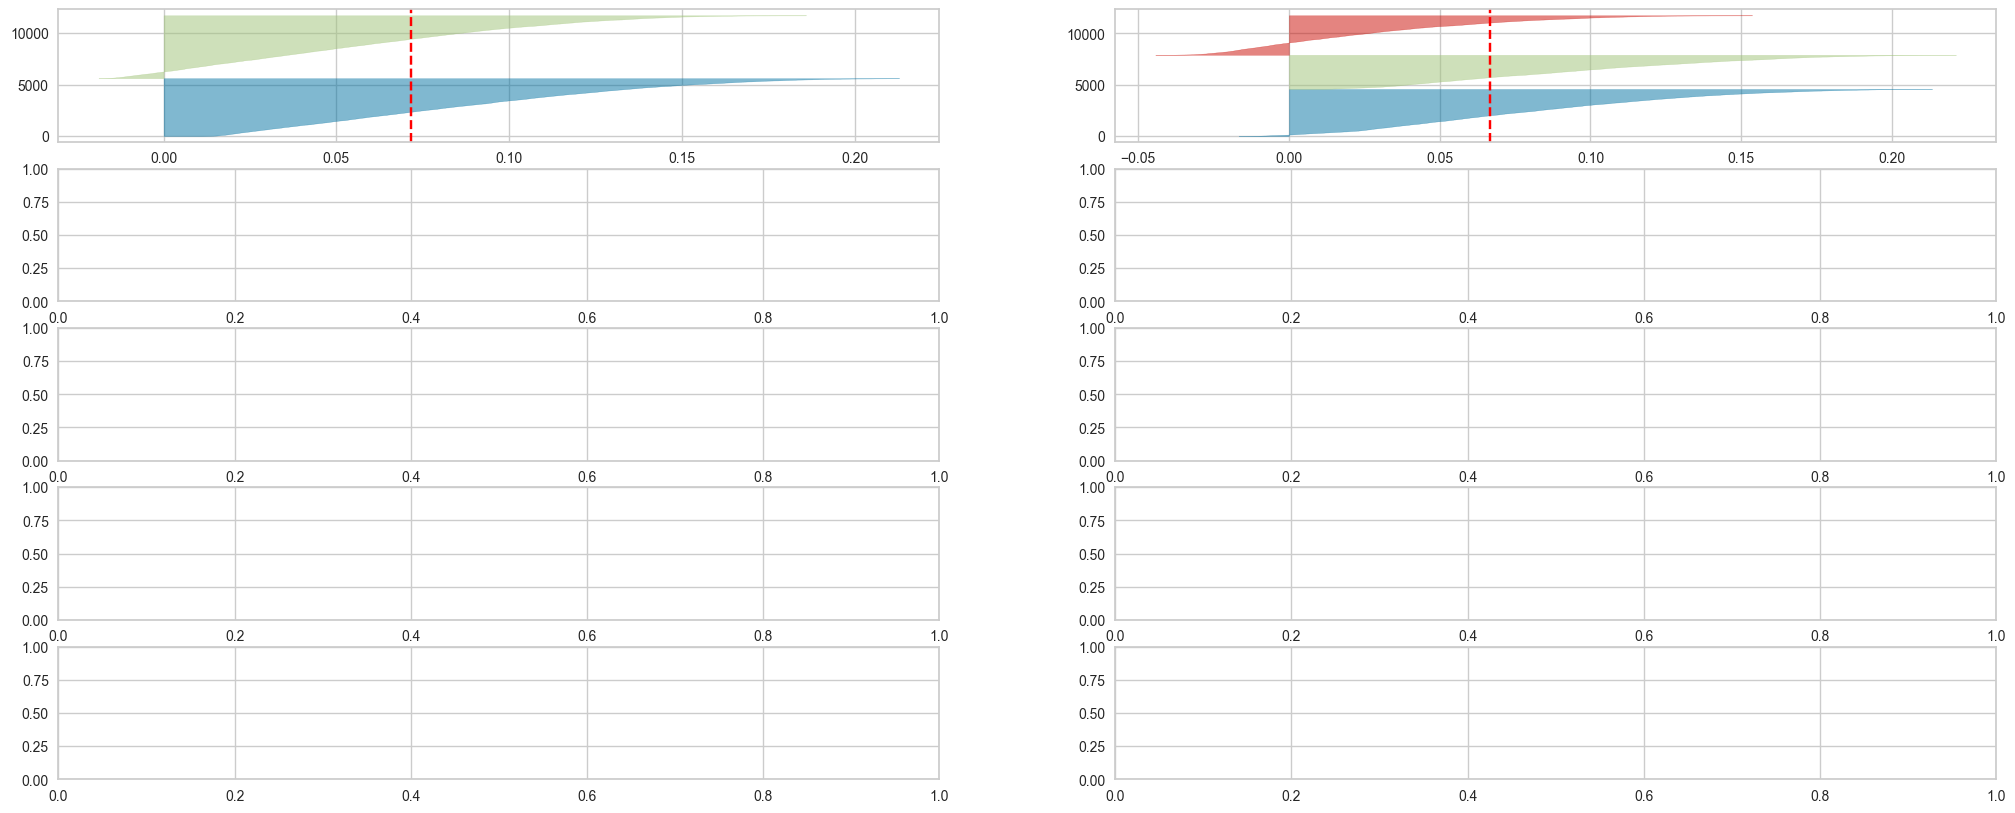

In [8]:
 
fig, ax = plt.subplots(5, 2, figsize=(25,10))
silhouette_avg = []
sse = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
for i in range_n_clusters:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)

    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data)
    
    #silhouette score
    ss = silhouette_score(data, km.labels_)
    silhouette_avg.append(ss)

    # use SSE for elbow method
    sse.append(km.inertia_)

    # Display which iteration we are on
    print(i, " no. of clusters yields an average silhuette score of: ", ss)

print("Rember that you should choose cluster size so that the clusters are relatively equal in size")

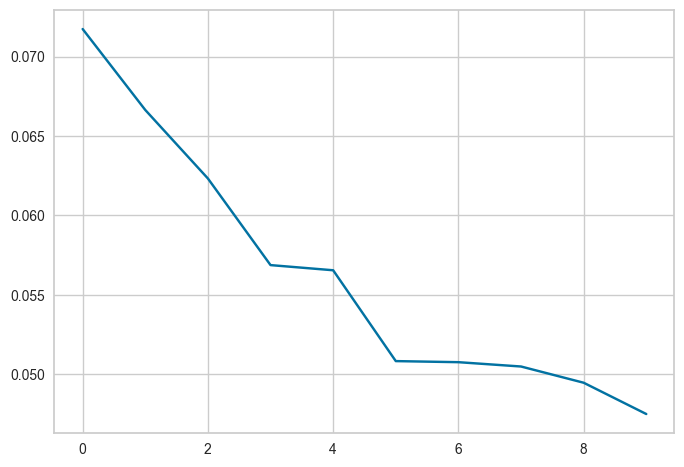

In [6]:
plt.plot(silhouette_avg)


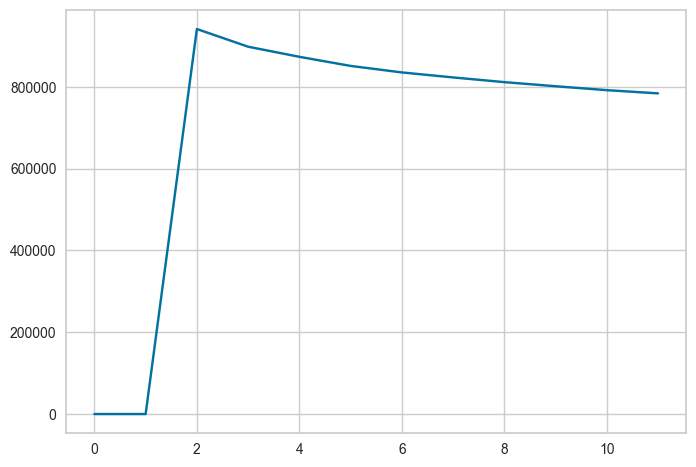

In [7]:
plt.plot([0, 0] + sse)

In [141]:
 km = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=100, random_state=42).fit(data)

In [142]:
df['cluster']=km.labels_
df

,index,title,year,wos,en,link,abstract,citations,clean_abstract,abstract_length,cluster
0,0,Financing Climate Change Adaptation: Internati...,2021.0,WOS:000666451800001,True,"<a href=""https://www.webofscience.com/wos/wosc...",Climate change adaptation is one of the main s...,27,one main strategy address global least develop...,64,1
1,1,Driving the agenda for climate change adaptati...,2013.0,WOS:000320956800008,True,"<a href=""https://www.webofscience.com/wos/wosc...",The absence of clear signals from the Norwegia...,55,absence clear signal norwegian state concernin...,62,1
2,2,Climate change adaptation policies and plans: ...,2018.0,WOS:000417078200110,True,"<a href=""https://www.webofscience.com/wos/wosc...",Building a climate-ready adaptation society is...,48,building ready society urgent question cannot ...,167,0
3,3,Place-based climate change adaptation: A criti...,2014.0,WOS:000345061100013,True,"<a href=""https://www.webofscience.com/wos/wosc...",Climate change adaptation frameworks often emp...,66,framework often emphasize tangible community v...,113,0
4,4,Responsibility for private sector adaptation t...,2014.0,WOS:000338711600014,True,"<a href=""https://www.webofscience.com/wos/wosc...",The Intergovernmental Panel on Climate Change ...,56,intergovernmental panel 2007 indicates vulnera...,168,1
...,...,...,...,...,...,...,...,...,...,...,...
11722,11845,Grabbed Urban Landscapes: Socio-spatial Tensio...,2019.0,WOS:000456253500009,True,"<a href=""https://www.webofscience.com/wos/wosc...",Cities confronted with unsustainable developme...,85,city confronted unsustainable development clim...,127,0
11723,11846,Large-scale and local climatic controls on lar...,2020.0,WOS:000506491300001,True,"<a href=""https://www.webofscience.com/wos/wosc...",Rangeland ecosystems worldwide are characteriz...,69,rangeland ecosystem worldwide characterized hi...,262,1
11724,11847,Public Health Measures to Address the Impact o...,2022.0,WOS:000873289500001,True,"<a href=""https://www.webofscience.com/wos/wosc...",Background: The World Health Organization iden...,49,background world health organization identifie...,131,0
11725,11848,A new framework for flood adaptation: introduc...,2022.0,WOS:000877017100001,True,"<a href=""https://www.webofscience.com/wos/wosc...",Traditional flood risk paradigms and associate...,143,traditional flood risk paradigm associated str...,156,0


In [145]:
df.iat[2489,2] = 2022.0
df['year'] = df['year'].astype(str)


search = [['Are there social limits to adaptation to climate change?','2009.0'],
          ['Limits to adaptation to climate change: a risk approach','2013.0'],
          ['Explaining and overcoming barriers to climate change adaptation','2014.0'],
          ['Contrasting perspectives on barriers to adaptation in Australian climate change policy','2014.0'],
          ['From barriers to limits to climate change adaptation: path dependency and the speed of change','2015.0'],
          ['A systematic global stocktake of evidence on human adaptation to climate change','2021.0'],
          ['Mapping the evolution and current trends in climate change adaptation science','2021.0'],
          ['Climate Change Adaptation on Small Island States: An Assessment of Limits and Constraints','2021.0'],
          ['Limits to adaptation: Building an integrated research agenda','2022.0'],
          ['A framework to diagnose barriers to climate change adaptation', '2010.0'],
          ['Limits to adaptation', '2013.0'],
          ['Everyday limits to adaptation', '2022']
          ]

def find_article(searchinfo):
    df_search = pd.DataFrame()
    for search in searchinfo:
        count = 0
        for title,year in zip(df['title'],df['year']):
            if search[0] == title and search[1] == year:
                df_search = pd.concat([df_search,df[count:count+1]], ignore_index = True)
            count = count + 1
    return df_search
df_search = find_article(search)
df_search

,index,title,year,wos,en,link,abstract,citations,clean_abstract,abstract_length,cluster
0,7926,Are there social limits to adaptation to clima...,2009.0,WOS:000264477100004,True,"<a href=""https://www.webofscience.com/wos/wosc...",While there is a recognised need to adapt to c...,101,while recognised need adapt changing climatic ...,89,0
1,1727,Limits to adaptation to climate change: a risk...,2013.0,WOS:000325741500016,True,"<a href=""https://www.webofscience.com/wos/wosc...",As attention to adaptation to climate change i...,42,a attention increase growing call approach foc...,80,0
2,1293,Explaining and overcoming barriers to climate ...,2014.0,WOS:000344597000018,True,"<a href=""https://www.webofscience.com/wos/wosc...",The concept of barriers is increasingly used t...,81,concept barrier increasingly used describe obs...,46,0
3,1834,From barriers to limits to climate change adap...,2015.0,WOS:000362913100019,True,"<a href=""https://www.webofscience.com/wos/wosc...",Research on the barriers and limits to climate...,57,barrier limit identifies many factor describes...,81,0
4,660,A systematic global stocktake of evidence on h...,2021.0,WOS:000712348000004,True,"<a href=""https://www.webofscience.com/wos/wosc...",Assessing global progress on human adaptation ...,142,assessing global progress human urgent priorit...,115,1
5,168,Mapping the evolution and current trends in cl...,2021.0,WOS:000663363200009,True,"<a href=""https://www.webofscience.com/wos/wosc...",Research on climate change adaptation has incr...,200,increased number significance since 1970s yet ...,133,1
6,8526,Climate Change Adaptation on Small Island Stat...,2021.0,WOS:000666143900001,True,"<a href=""https://www.webofscience.com/wos/wosc...",Small Island States (SIDS) are among the natio...,118,small island state sids among nation exposed c...,123,0
7,2491,Limits to adaptation: Building an integrated r...,2022.0,WOS:000898815700001,True,"<a href=""https://www.webofscience.com/wos/wosc...",The IPCC's Sixth Assessment Report Working Gro...,99,ipcc sixth assessment report working group ii ...,78,0
8,289,A framework to diagnose barriers to climate ch...,2010.0,WOS:000285521800020,True,"<a href=""https://www.webofscience.com/wos/wosc...",This article presents a systematic framework t...,64,present systematic framework identify barrier ...,98,0


In [143]:
#splitting dataset into clusters
df0 = df[df['cluster'] == 0].reset_index().loc[:,'title':'cluster']
df1 = df[df['cluster'] == 1].reset_index().loc[:,'title':'cluster']
#df2 = df[df['cluster'] == 2].reset_index().loc[:,'title':'cluster']

#df_list = [df0, df1, df2]

In [156]:
#!pip install bertopic
from bertopic import BERTopic

topic_model = BERTopic(top_n_words=12,
                        #min_topic_size=50,
                        nr_topics= 10)



In [97]:
for x in df_list:
    topic, probs = topic_model.fit_transform(x['clean_abstract'])
                                         
dftest = pd.DataFrame()
dftest['Topic'] = topic_model.get_topic_info()['Topic']
dftest['Count'] = topic_model.get_topic_info()['Count']
dftest['Name'] = topic_model.get_topic_info()['Name']
dftest.to_csv('topics_cluster_'+str(x))

OSError: Cannot save file into a non-existent directory: 'topics_cluster_                                                  title    year  \
0     Responsibility for private sector adaptation t...  2014.0   
1     Coastal Adaptation Planning in Fairbourne, Wal...  2020.0   
2     Everyday realities of climate change adaptatio...  2012.0   
3     Adaptation to climate change and resettlement ...  2015.0   
4     Prioritization of climate change adaptation ap...  2014.0   
...                                                 ...     ...   
3835  Coastal flood analysis and visualisation for a...  2015.0   
3836  Artificial intelligence to predict West Nile v...  2022.0   
3837  How to plan urban green space in cold regions ...  2022.0   
3838  Grabbed Urban Landscapes: Socio-spatial Tensio...  2019.0   
3839  A new framework for flood adaptation: introduc...  2022.0   

                      wos    en  \
0     WOS:000338711600014  True   
1     WOS:000513893900001  True   
2     WOS:000304290100022  True   
3     WOS:000349463000014  True   
4     WOS:000344801000003  True   
...                   ...   ...   
3835  WOS:000364436700024  True   
3836  WOS:000796373200002  True   
3837  WOS:000767069800001  True   
3838  WOS:000456253500009  True   
3839  WOS:000877017100001  True   

                                                   link  \
0     <a href="https:\www.webofscience.com\wos\wosc...   
1     <a href="https:\www.webofscience.com\wos\wosc...   
2     <a href="https:\www.webofscience.com\wos\wosc...   
3     <a href="https:\www.webofscience.com\wos\wosc...   
4     <a href="https:\www.webofscience.com\wos\wosc...   
...                                                 ...   
3835  <a href="https:\www.webofscience.com\wos\wosc...   
3836  <a href="https:\www.webofscience.com\wos\wosc...   
3837  <a href="https:\www.webofscience.com\wos\wosc...   
3838  <a href="https:\www.webofscience.com\wos\wosc...   
3839  <a href="https:\www.webofscience.com\wos\wosc...   

                                               abstract  citations  \
0     The Intergovernmental Panel on Climate Change ...         56   
1     Adaptation to climate change is emerging as a ...         79   
2     This paper analyzes discourses and practices o...         59   
3     During the last ten years, adaptation to clima...         49   
4     Adaptation to climate change has been recogniz...         62   
...                                                 ...        ...   
3835  Extreme sea levels and floods are a widespread...         72   
3836  Background In Europe, the frequency, intensity...         87   
3837  With the acceleration of urbanization, the urb...         76   
3838  Cities confronted with unsustainable developme...         85   
3839  Traditional flood risk paradigms and associate...        143   

                                         clean_abstract  abstract_length  '

In [157]:
topic, probs = topic_model.fit_transform(df1['clean_abstract'])
dftest = pd.DataFrame()
dftest['Topic'] = topic_model.get_topic_info()['Topic']
dftest['Count'] = topic_model.get_topic_info()['Count']
dftest['Name'] = topic_model.get_topic_info()['Name']

In [162]:
topic_model.get_topics()

{-1: [('water', 0.023529559205126255),
  ('farmer', 0.022012079965230413),
  ('impact', 0.017898715940640103),
  ('crop', 0.01671475069387533),
  ('agricultural', 0.014366729905992732),
  ('system', 0.014244129277549306),
  ('strategy', 0.0141170922175953),
  ('model', 0.013909435414974778),
  ('result', 0.013645422055169365),
  ('area', 0.013356618496687305),
  ('drought', 0.01297018894810674),
  ('use', 0.012739741465072152)],
 0: [('water', 0.024081153990528195),
  ('urban', 0.022192439153421957),
  ('heat', 0.01974155477390103),
  ('temperature', 0.019091286960857316),
  ('model', 0.01780398550944074),
  ('energy', 0.017244170168294305),
  ('extreme', 0.01674376922489833),
  ('risk', 0.015986359855241085),
  ('future', 0.01576062798535781),
  ('result', 0.015672156053967753),
  ('building', 0.014757417186882504),
  ('city', 0.01459637988521601)],
 1: [('farmer', 0.035185960997907315),
  ('yield', 0.023732635261462513),
  ('crop', 0.023236713140780272),
  ('food', 0.0201312959850288

In [161]:
dftest

,Topic,Count,Name
0,-1,2530,-1_water_farmer_impact_crop
1,0,1461,0_water_urban_heat_temperature
2,1,1233,1_farmer_yield_crop_food
3,2,319,2_coastal_sea_level_fishery
4,3,181,3_health_disease_human_dengue
5,4,175,4_indigenous_knowledge_glacier_arctic
6,5,67,5_woman_gender_female_household
7,6,58,6_migration_tourism_tourist_destination
8,7,43,7_wine_grape_vineyard_viticulture
9,8,43,8_coffee_cocoa_production_farmer


ALT UNDER ER REDUNDANT

In [19]:
n_clusters = 5

preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=n_clusters,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
)

pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)


In [20]:
pipe.fit(data)


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

In [21]:
preprocessed_data = pipe["preprocessor"].transform(data)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)


0.9600019587810832

In [22]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

kmeans.fit(data)



KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [ ]:
# The lowest SSE value
print(kmeans.inertia_)


# Final locations of the centroid
print(kmeans.cluster_centers_)


# The number of iterations required to converge
print(kmeans.n_iter_)

label = kmeans.fit_predict(data)


11159.916310040553
[[ 3.60997303e-05  6.49211535e-04 -1.28749008e-19 ... -1.35525272e-20
  -1.69406589e-21  7.96210970e-20]
 [ 6.81474803e-04  1.02540189e-03 -8.47032947e-22 ...  1.62787341e-04
   1.18584613e-20 -2.20228566e-20]
 [ 5.18693533e-04  1.97148516e-03  1.81446008e-05 ...  2.37169225e-20
   2.13531383e-05  2.10198471e-05]]
23


In [23]:
# A list holds the SSE values for each k
run = True

if run:
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        print(k)


1


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 180, in where
  File "C:\Users\ntn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\multiarray.py", line 345, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 
